In [ ]:
import os
from PIL import Image
import cv2
import torch.utils.data as torch_data
import torchvision
import torch
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import random

In [ ]:
save_path = '../7d_vae/{}'
code_size = 7

train = 1
beta = 0
early_stopping = 1
if early_stopping:
    epochs = 100 #for early stopping only 


#to make figures
reg = 0
interp = 1
plots_2d = 0
m_tsne = 0

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f'Selected device: {device}')
print(torch.version.cuda)

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab_Notebooks/padded_300/hydra_images/hydra_processed'
os.chdir(path)
print(os.getcwd())
print(len(os.listdir()))
#os.listdir(path)
image_folder = path

Selected device: cuda:0
11.3
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/padded_300/hydra_images/hydra_processed
10040


In [ ]:
class Dataset(torch_data.Dataset):
    """
    A class for feeding image data into the autoencoder
    
    Note RGB removed
    Ignore all functions that set labels
    __getitem__ modified to only give image (called batch when used by train_one_epoch())
    added min-max scaling to convert values to 1 and 0 to use binary cross entropy
    by using cv2.imread(path, 0) converts to greyscale putting into dimensions [1, 300, 300]
    added a property called orig_max - to later reverse min-max scaling
    paths in __init__ is modified to work in same notebook as execution - 
    so included the attribute image_folder
    
    
    """


    def __init__(self, img_transforms, image_folder):
        """
        - transforms: transforms to apply to the images
        - RGB: whether to process in color
        - image_folder: data directory

        """
        self.img_transforms = img_transforms
        self.image_folder = image_folder
        
        #append all filenames 
        self.paths = [file for file in os.listdir(self.image_folder) if file.endswith('.png')]    

        self.labels = [0 for path in self.paths]


    def __getitem__(self, index):

        path = self.paths[index]
        label = self.labels[index]

        image = cv2.imread(path, 0)#grey scale 3->1

        image = Image.fromarray(image)
        

        image = self.img_transforms(image)
        
        #min-max scaling so values take 1 or 0
        image = torch.div(image, torch.max(image))

        return (path, image, label)


    def __len__(self):
        return len(self.labels)

In [ ]:
#functions from utils

def get_lims_from_points(points):
    xs, ys = [], []
    for item in points:
        xs.append(item[0][0])
        ys.append(item[0][1])
    min_x, max_x, min_y, max_y = min(xs), max(xs), min(ys), max(ys)
    return min_x, max_x, min_y, max_y

def _standardize_coords(coords, orig_lims):
    [xmin, xmax, ymin, ymax] = orig_lims
    x_new = -10 + 20*(coords[0]-xmin)/(xmax-xmin)
    y_new = -10 + 20*(coords[1]-ymin)/(ymax-ymin)
    return [x_new, y_new]


class Flatten(torch.nn.Module):
    def forward(self, batch):
        return batch.view(batch.shape[0], -1)

class UnFlatten(torch.nn.Module):
    def __init__(self, num_reps, height, width):
        super(UnFlatten, self).__init__()
        self.num_reps = num_reps
        self.height = height
        self.width = width
    def forward(self, batch):
        return batch.view(batch.shape[0], self.num_reps, self.height, self.width)

#
flatten = Flatten()

In [ ]:
#visualization class
#Here we only use code_projections_2D


class Visualizations_Mixin:

    def code_projections_2D(self, im_size, save_path, proj_sampling_rate):
        """
        inherit this function using VAE - so can run VAE.code_projections_2D()
        likewise implement_autoencoder inherits so:
        implement_autoencoder.VAE.code_projections_2D((200, 200)
         save_path = implement_autoencoder.save_path, proj_sampling_rate = 15)

        Sample code space on grid and visualize the features the network
        is capturing.
        Args:
        - im_size: tuple of dimensions of each image on the grid.
        - save_as: filename to save image as.
        - proj_sampling_rate: number of samples along each axis.
        """

        self.eval()

        # set the limits of the grid to project from to be either data_lims (set by running the function that
        # finds the min & max of data embeddings), or lims_list which is specified when initializing the VAE class
        if self.data_limits is None:
            min_x, max_x = self.lims_list[0], self.lims_list[1]
            min_y, max_y = self.lims_list[2], self.lims_list[3]
        else:
            min_x, max_x = self.data_limits[0], self.data_limits[1]
            min_y, max_y = self.data_limits[2], self.data_limits[3]

        im_array = np.zeros((int(max_y) - int(min_y), int(max_x) - int(min_x)))

        # split the code space into grid
        grid_xs = np.linspace(min_x, max_x, proj_sampling_rate)
        grid_ys = np.linspace(min_y, max_y, proj_sampling_rate)
        x_im_width = grid_xs[1]-grid_xs[0]
        y_im_width = grid_ys[1]-grid_ys[0]

        # dimension of each image to be plottted
        im_dimension = 200

        # empty array to fill with the images
        array = np.zeros( ( im_dimension * len(grid_ys), im_dimension * len(grid_xs) ) )

        fig = plt.figure(figsize = (50, 50))
        # i, j for placement in empty array; x, y initial codes
        for i, x in enumerate(grid_xs):
            x += (x_im_width/5) # so spore is at code point
            for j, y in enumerate(grid_ys):
                y += y_im_width/2
                code = torch.tensor([x, y], dtype = torch.float32)
                code = torch.unsqueeze(code, 0)
                code = code.to(device)
                #batch = F.relu(batch)
                code = self.fc2(code)
                batch = self.decoder(code)

                batch = batch.view(*im_size)
                im = batch.detach().cpu().numpy() # need to detach from graph before it can be turned into array

                im = cv2.resize(im, (im_dimension, im_dimension))

                row1 = im_dimension * j
                row2 =  im_dimension * j + im_dimension
                col1 = im_dimension * i
                col2 = im_dimension * i + im_dimension
                array[row1:row2, col1:col2] = im[::-1, :] # filling the empty array with the images

        array = array[::-1, :]*255

        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
        plt.imshow(array, cmap='gray')
        plt.savefig(save_path.format('code_projections'))
        plt.close()

        self.proj_array = array
        self.proj_array_im_dim = im_dimension
        self.proj_sampling_rate = proj_sampling_rate



In [ ]:
class VAE(torch.nn.Module, Visualizations_Mixin):
    """
    Variational Autoencoder (with beta = 0 this becomes a regular autoencoder, as used in the paper)
    """

    def __init__(self, code_size, beta, learning_rate, batch_size, lims_list):
        """
        - code_size
        - beta: KLD weighting in loss
        - learning_rate
        - batch_size
        - lims_list: minimum and maximum along each morphospace dimension for visualizations; [xmin, xmax, ymin, ymax]
        """
        super(VAE, self).__init__()

        self.learning_rate = learning_rate
        self.code_size = code_size
        self.batch_size = batch_size
        self.beta = beta

        self.lims_list = lims_list #declared in run_morphospace.py, change later to worm specif values
        self.data_limits = None # a switch for visualization, for axis limits
        self.points = None #by calling fx turns into a list of embeddings

        self.num_epochs_trained = 0
        self.BCE = []
        self.BCE_plot = []


        self.input_dims = [300, 300] #change for image height/width
        ########################################################################
        act_func = torch.nn.ReLU()
        final_act = torch.nn.Sigmoid()
        ##############################

        conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        bn1 = torch.nn.BatchNorm2d(16)
        
        conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        bn2 = torch.nn.BatchNorm2d(32)
        
        conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        bn3 = torch.nn.BatchNorm2d(64)
        
        conv4 = torch.nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1)
        bn4 = torch.nn.BatchNorm2d(16)


        self.encoder = torch.nn.Sequential(conv1, bn1, act_func,
                                         conv2, bn2, act_func,
                                         conv3, bn3, act_func,
                                         conv4, bn4, act_func,
                                         Flatten())
        self.encoder.apply(self.init_weights)
        ########################################################################
        #make sure linear layer is 300*300 neurons
        self.fc11 = torch.nn.Linear(90000, self.code_size)
        self.fc12 = torch.nn.Linear(90000, self.code_size) #for batch normalization
        self.fc2 = torch.nn.Linear(self.code_size, 90000)
        
        for i in [self.fc11, self.fc12, self.fc2]:
            i.apply(self.init_weights)
        ########################################################################

        conv5 = torch.nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        bn5 = torch.nn.BatchNorm2d(64)
        
        conv6 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        bn6 = torch.nn.BatchNorm2d(32)
        
        conv7 = torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        bn7 = torch.nn.BatchNorm2d(16)
        
        conv8 = torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)

        self.decoder = torch.nn.Sequential(UnFlatten(16, 75, 75), #change to 75 for worm image dimensions
                                            conv5, bn5, act_func, 
                                            conv6, bn6, act_func, 
                                            conv7, bn7, act_func,
                                             conv8, final_act)
        self.decoder.apply(self.init_weights)
        ########################################################################

    def init_weights(self, m):
        """
        Xavier initialization
        """
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def set_data_limits(self, dataloader):
        """
        Find and set as attribute the morphospace limits, for visualizations

        as an alternative to self.lims_list, this fx looks at the embeddings to
        get the min and max for the set of embeddings 
        which is used in the visualization script to set the axis limits 
        """

        self.eval()#dont calaculate gradients

        xs, ys = [], []
        for i, tup in enumerate(dataloader):
            if i % 100 == 0:
                print('batch {}'.format(i))
                sys.stdout.flush()
            paths, batch, labels = tup[0], tup[1], tup[2]
            batch = batch.type('torch.FloatTensor').to(device)
            labels = labels.to(device)

            intermediate = batch

            intermediate = self.encoder(intermediate)
            mu_ = self.fc11(intermediate) #code space
            mu_ = mu_.data.cpu().numpy() #take out of cuda and handle with numpy

            labels_ = labels.data.cpu().numpy()
            for idx in range(mu_.shape[0]): #get each image in batch
                xs.append(mu_[idx, :][0]) #embedding 1
                ys.append(mu_[idx, :][1]) #embedding 2

        self.data_limits = (min(xs), max(xs), min(ys), max(ys)) #axis limits for visualisation 

    def _reparametrize(self, mu, logvar):
        """
        Central reparametrization
        Args:
        - mu: mean of stochastic embedding.
        - logvar: logarithm variable.

        batch normalization for the code spcae
        """

        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device) # default mean 0, std 1
        return eps.mul(std).add_(mu)


    def forward(self, x):
        """
        Propagate batch
        Args:
        - x: batch to flow through.
        """
        x = self.encoder(x)

        mu = self.fc11(x)
        logvar = self.fc12(x)
        x = self._reparametrize(mu, logvar)

        x = self.fc2(x)

        recon_x = self.decoder(x)

        return mu, logvar, recon_x

    def _custom_loss(self, recon_x, x, mu, logvar):
        """
        Loss is reconstruction and weighted KLD. The latter is difference between unit Gaussian
        and each point's stochastic (and also Gaussian) embedding.
        Args:
        - recon_x: reconstuction
        - x: input data
        - mu: mean of stochastic embedding.
        - logvar: log variable of stochastic embedding.
        """

        #bce = F.binary_cross_entropy(torch.add(recon_x, 1e-10), x, size_average=False)
        bce = F.binary_cross_entropy(recon_x, x, size_average=False)
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        loss = bce + self.beta*kld.sum()

        bce /= x.shape[0]
        kld_loss = self.beta*kld.sum()/x.shape[0]
        loss /= x.shape[0]

        return bce, kld_loss, loss


    def train_oneEpoch(self, dataloader, save_recons_path = save_path):
        """
        Train the model for one epoch.
        Args
        - dataloader: PyTorch dataloader object
        - save_recons_path: where to save reconstructions each epoch
        """

        self.train()

        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)


        MSE_losses = []
        KLD_losses = []

        for i, tup in enumerate(dataloader):
            start_time = time.time()

            if i % 50 == 0:
                print('batch {}'.format(i))
                sys.stdout.flush()

            _, batch, _ = tup[0], tup[1], tup[2]


            batch = batch.type('torch.FloatTensor').to(device)

            # forward
            mu, logvar, x = self.forward(batch) #code error, put forward
            #print(torch.unique(x))
            #sys.stdout.flush()

            if save_recons_path is not None:
                # visualise some reconstructions
                if i == 10:

                    fig, axarr = plt.subplots(6, 6, figsize=(70, 40))
                    count = 0
                    for row_start in [0, 2, 4]:
                        for col in range(6):
                            axarr[row_start, col].imshow(batch.detach().cpu().view(batch.size(0), self.input_dims[0], self.input_dims[1])[count + col, :], cmap = 'gray')
                            axarr[row_start, col].set_title('{}_{}'.format(torch.min(batch).item(), torch.max(batch).item()))
                            axarr[row_start + 1, col].imshow(x.detach().cpu().view(x.size(0), self.input_dims[0], self.input_dims[1])[count + col, :], cmap='gray') # detach as can't call numpy() on requires_grad var
                            axarr[row_start + 1, col].set_title('{}_{}'.format(torch.min(x).item(), torch.max(x).item()))
                        count += 6
                    plt.axis('off')
                    plt.savefig(save_recons_path.format(self.num_epochs_trained))
                    plt.close(fig)


            MSE, beta_KLD, loss = self._custom_loss(x, batch, mu, logvar)
            #print(MSE.item())
            #sys.stdout.flush()

            MSE_losses.append(MSE.item())
            KLD_losses.append(beta_KLD.item())
            self.BCE.append(MSE.item())

            # backward pass
            optimizer.zero_grad() #clear gradients for iteration
            loss.backward() #backpropogation 
            optimizer.step() #update gradients

        print('Epoch {}, MSE_loss: {}, KLD_loss: {}, Loss: {}'.format(self.num_epochs_trained, MSE, beta_KLD, loss.item()))
        self.num_epochs_trained += 1
        self.BCE_plot.append(loss.item())
        


    def harvest_points(self, dataloader):
        """
        Save embeddings as a class attribute (self.points).
        Args
        - dataloader: PyTorch dataloader object to be modelled.

        for each make a list of embeddings to be used in the visualization script
        """

        self.eval() #dont update gradients 

        points = []
        for i, tup in enumerate(dataloader):
            if i % 100 == 0:
                print('batch {}'.format(i))
                sys.stdout.flush()

            paths, batch, labels = tup[0], tup[1], tup[2]
            batch = batch.type('torch.FloatTensor').to(device)
            labels = labels.to(device)

            batch = self.encoder(batch)
            mu_ = self.fc11(batch)
            mu_ = mu_.data.cpu().numpy()

            labels_ = labels.data.cpu().numpy()
            for idx in range(mu_.shape[0]):
                points.append([mu_[idx, :], labels_[idx], paths[idx]]) #list of code space

        self.points = points




    def save(self):
        """
        Save the model's state_dict under arg: save_path.
        """
        torch.save(self.state_dict(), save_path.format('model_parameters.pth.tar'))


    def load(self):
        """
        Load the model's state_dict from arg: path.
        """
        self.load_state_dict(torch.load(save_path.format('model_parameters.tar') , map_location=torch.device(device)))




In [ ]:
class Implement_Autoencoder():
    """
    Class for operations using the VAE class.
    """


    def __init__(self, code_size, beta, lr, batch_size, lims_list, save_path):
        """
        Args
        - code_size: dimensionality of the morphospace
        - beta: weighting of the Kullback-Leibler divergence in the VAE loss (this is zero for a plain autoencoder)
        - lr: learning rate
        - batch_size
        - save_path: path to save visualizations to. Must include '{}' to be formatted with visualization-specific string
        """

        self.code_size = code_size
        self.beta = beta
        self.lr = lr
        self.batch_size = batch_size
        self.save_path = save_path

        self.VAE = None
        
        # for dataloader
        self.img_transforms = torchvision.transforms.Compose(  [torchvision.transforms.ToTensor()] ) # convert images to PyTorch tensor objects
        self.image_folder = image_folder
        
        self.lims_list = lims_list


    def load_model(self):
        """
        Load the neural network state_dict from disk.
        """

        self.VAE = VAE(self.code_size, self.beta, self.lr, self.batch_size, self.lims_list).to(device)
        self.VAE.load()


    def train_and_save_model(self, num_epochs_train):
        """
        Train and save state_dict.
        """
        self.VAE = VAE(self.code_size, self.beta, self.lr, self.batch_size, self.lims_list).cuda()
        dataset = Dataset(self.img_transforms, self.image_folder) #, RGB = False) modify dataset to get this 
        #dataset.drug_labelled() #modify dataset to get this

        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)

        
        for epoch in range(num_epochs_train):
            self.VAE.train_oneEpoch(train_dataloader)
            #path_to_here = os.path.dirname(os.path.realpath(__file__))
            #self.VAE.save(path_to_here+'/../outputs/autoencoder_{}.pth.tar'.format(self.VAE.num_epochs_trained))

            #lots of visualization stuff to add in later


    def set_data_limits_all(self):
        """
        Find the minimum and maximum along each morphospace dimension (for plotting visualizations)
        """
        dataset = Dataset(self.img_transforms, self.image_folder) #, RGB = False)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)
        self.VAE.set_data_limits(dataloader)


In [ ]:

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

        self.img_transforms =  torchvision.transforms.Compose(  [torchvision.transforms.ToTensor()] ) # convert images to PyTorch tensor objects
        self.image_folder = image_folder
        self.batch_size = 50

        self.val_loss = []


    def __call__(self, val_loss, model):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
        if self.counter == 1:
            model.save()
            

    #run validation


    def validate_oneEpoch(self, model, dataloader):
        model.eval()
        loss_total = 0 

        with torch.no_grad():
            for i, tup in enumerate(dataloader):
                _, batch, _ = tup[0], tup[1], tup[2]
                batch = batch.type('torch.FloatTensor').to(device)
                mu, logvar, x = model.forward(batch)
                _, _, loss = model._custom_loss(x, batch, mu, logvar)
                loss_total += loss.item()  #sum loss scores

        self.val_loss.append(loss_total/len(valid_loader)) #average loss across batch
        print('Epoch {}, loss: {}'.format(epoch, self.val_loss[-1]))
            

In [ ]:
class Dataset_recon(torch_data.Dataset):
    """
    a consistent dataset of 36 images 
    to compare model variants
    """


    def __init__(self, img_transforms, image_folder):
        """
        - transforms: transforms to apply to the images
        - RGB: whether to process in color
        - image_folder: data directory

        """
        self.img_transforms = img_transforms
        self.image_folder = image_folder
        
        #append all filenames 
        self.paths = reg_set 

        self.labels = [0 for path in self.paths]


    def __getitem__(self, index):

        path = self.paths[index]
        label = self.labels[index]

        image = cv2.imread(path, 0)#grey scale 3->1

        image = Image.fromarray(image)
        

        image = self.img_transforms(image)
        
        #min-max scaling so values take 1 or 0
        image = torch.div(image, torch.max(image))

        return (path, image, label)


    def __len__(self):
        return len(self.labels)

def val_18():
    """
    return a consistent set of 36 random images
    to evaluate model variants
    """
    random.seed(42)
    reg_ix = [random.randint(1, 10000) for i in range(18)]
    big_set = [file for file in os.listdir() if file.endswith('.png')]
    reg_set = [big_set[i] for i in reg_ix]
    return reg_set


def no_ax(im):
    im.axes.get_xaxis().set_visible(False)
    im.axes.get_yaxis().set_visible(False)

def regular_recon():


    es = EarlyStopping() #to access attributes
    dataset = Dataset_recon(es.img_transforms, es.image_folder)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 36, shuffle = False)

    #load trined model
    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()

    implement_autoencoder.eval()
    with torch.no_grad():

        iterator = iter(dataloader)
        _, batch, _  = next(iterator)
        #print(len(batch), type(batch))
        batch = batch.type('torch.FloatTensor').to(device)

        _, _, x = implement_autoencoder.forward(batch)


    #make reconstrunctions 

    plt.figure()
    fig, axarr = plt.subplots(6, 6, figsize=(10, 10))
    count = 0
    for row_start in [0, 2, 4]:
        for col in range(6):
            top = axarr[row_start, col].imshow(batch.detach().cpu().view(batch.size(0), 300, 300)[count + col, :], cmap = 'gray')
            no_ax(top)
            bottom = axarr[row_start + 1, col].imshow(x.detach().cpu().view(x.size(0),300, 300)[count + col, :], cmap='gray') # detach as can't call numpy() on requires_grad var
            no_ax(bottom)
        count += 6

    plt.axis('off')
    plt.savefig(save_path.format('consistent_reconstrunctions'))
    return plt.show()


In [ ]:
def interpolate_worms(var_emb, shrink =1,
                      start = -3, stop= 4, const_emb = [0.0]):
  
    """
    var_emb as iteratble index, for dimension varying
    """
    print(const_emb)
    #load trainined model 
    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()

    #number of images
    ncols = (stop+1) - start

    #instantiate an array to save reconstrunctions
    im_set = []
    values = const_emb*code_size

    implement_autoencoder.eval()
    with torch.no_grad():
        for i in range(start, stop+1): #for each image
            values[var_emb] = (i + 0.0)/shrink
            coord = torch.tensor(values, dtype = torch.float32)
            #print(coord)

            coord = torch.unsqueeze(coord, 0)
            coord = coord.to(device)
            coord = implement_autoencoder.fc2(coord)
            coord = implement_autoencoder.decoder(coord)
            batch = coord.view(*(300, 300))
            im = batch.detach().cpu().numpy()
            im_set.append(im)
    sns.set_style("darkgrid")
    plt.figure()
    f, axarr = plt.subplots(1, ncols, figsize =(30, 15)) 
    for i in range(ncols):
        axarr[i].imshow(im_set[i][: 250, :200], cmap='gray') #
    plt.savefig(save_path.format("interp_"+str(var_emb)+"_"))

    return plt.show()


In [ ]:
def dhist_3():

    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()

    es = EarlyStopping()
    harvest_dataset = Dataset(es.img_transforms, es.image_folder)
    harvest_dataloader = torch.utils.data.DataLoader(harvest_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.harvest_points(harvest_dataloader)
    print(len(implement_autoencoder.points))


    emb1, emb2, emb3 = [], [], []
    for worm in implement_autoencoder.points:
        emb1.append(worm[0][0])
        emb2.append(worm[0][1])
        emb3.append(worm[0][2])
    
    all_emb = [emb1, emb2, emb3]

    plt.figure()
    f, axarr = plt.subplots(1, code_size, figsize =(5, 7)) 
    for i in range(code_size):
        axarr[i].hist(all_emb[i], bins=20)
    plt.savefig(save_path.format("hist_"+str(code_size)+"_d"))

    with open(save_path.format("hist.txt"), "w") as out_file:
        for i in all_emb:
            out_file.write(str(i))

    return plt.show()
    


In [ ]:
def dhist():

    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()

    es = EarlyStopping()
    harvest_dataset = Dataset(es.img_transforms, es.image_folder)
    harvest_dataloader = torch.utils.data.DataLoader(harvest_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.harvest_points(harvest_dataloader)
    print(len(implement_autoencoder.points))

    all_emb = [[]] * code_size
    print(all_emb)
    count = 0
    for worm in implement_autoencoder.points:
        count +=1
        for dim in range(code_size):
            all_emb[dim].append(worm[0][dim])
        
            if count > 10:
                break
    print(all_emb)
  

    plt.figure()
    f, axarr = plt.subplots(1, code_size, figsize =(7, 7)) 
    for i in range(code_size):
        axarr[i].hist(all_emb[i])
    plt.savefig(save_path.format("hist_"+str(code_size)))

    with open(save_path.format("hist.txt"), "w") as out_file:
        for i in all_emb:
            out_file.write(str(i) + "\n")

    return plt.show()
    

In [ ]:
if reg:
    reg_set = val_18()
    print(len(reg_set), "\n", reg_set)

    regular_recon()

[0.0]


<Figure size 432x288 with 0 Axes>

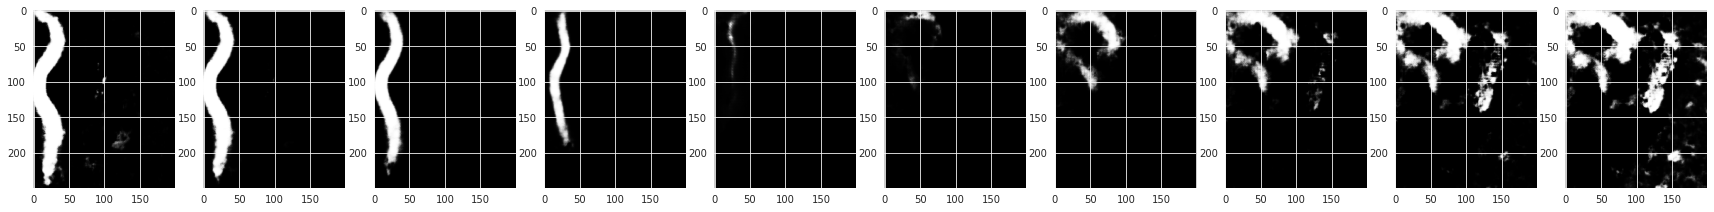

[0.0]


<Figure size 432x288 with 0 Axes>

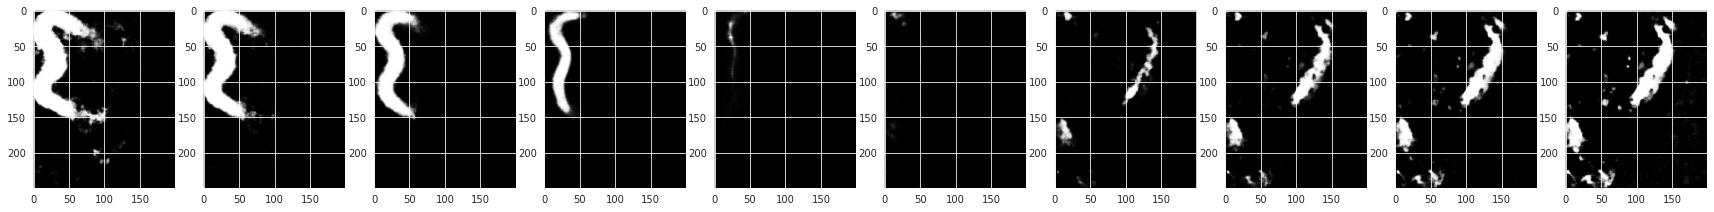

[0.0]


<Figure size 432x288 with 0 Axes>

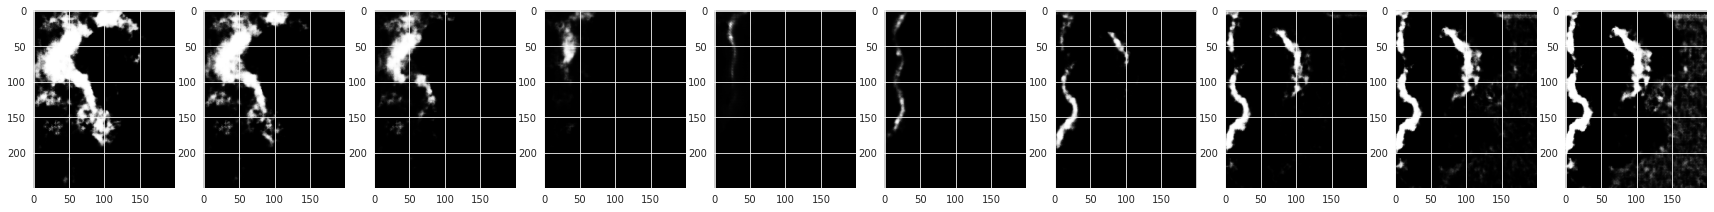

[0.0]


<Figure size 432x288 with 0 Axes>

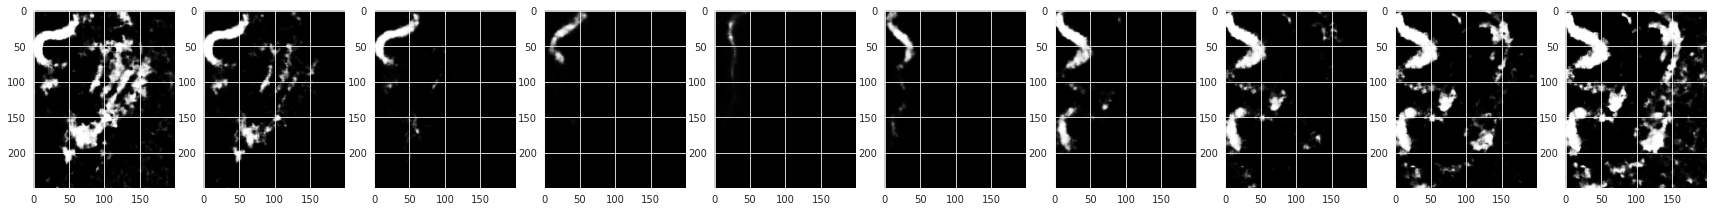

[0.0]


<Figure size 432x288 with 0 Axes>

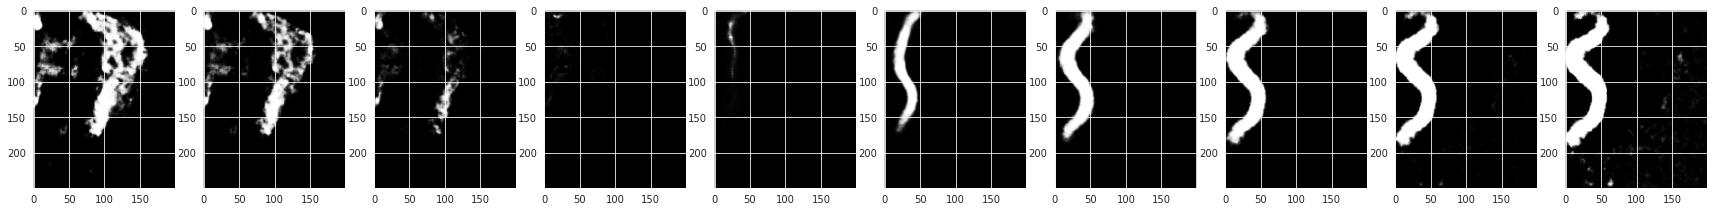

[0.0]


<Figure size 432x288 with 0 Axes>

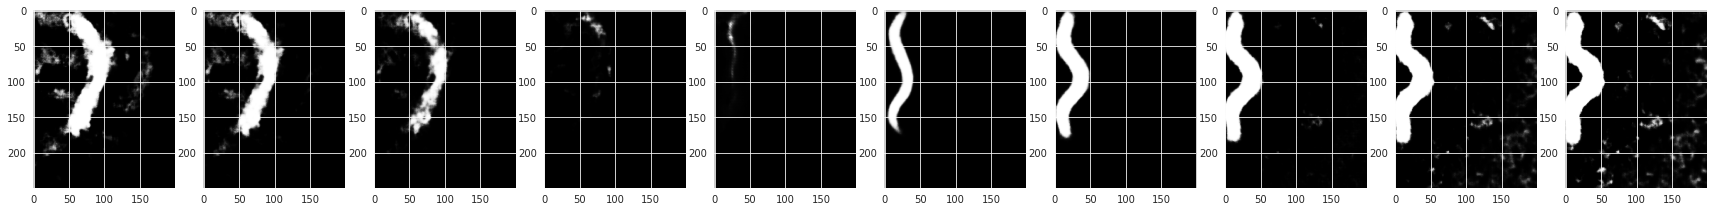

[0.0]


<Figure size 432x288 with 0 Axes>

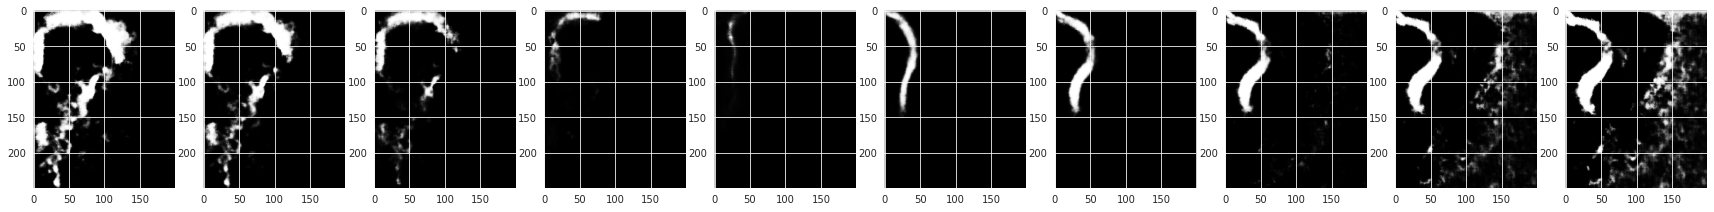

[0.0]


<Figure size 432x288 with 0 Axes>

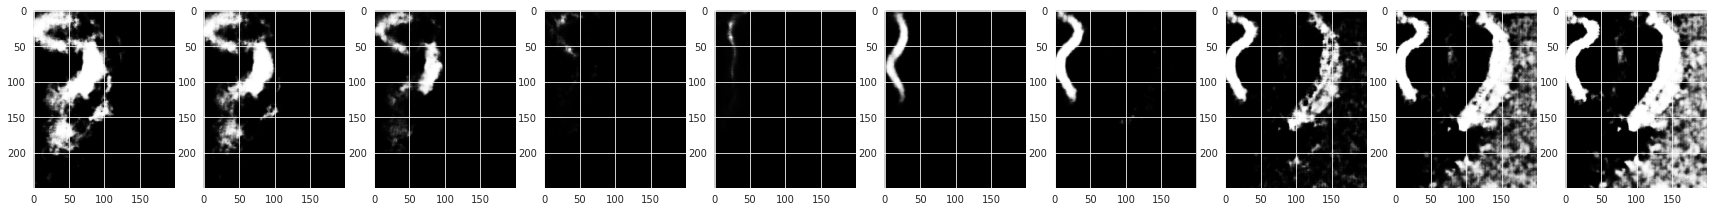

In [ ]:
if interp:
    if code_size == 7:
    # for 7d, 
        for i in range(code_size):
            interpolate_worms(i, start =-4, stop= 5, shrink=1/4)
    else:
        for i in range(code_size):
            interpolate_worms(i) 

In [ ]:
if plots_2d:

    #This cell finds data limits of latent space and extracts embedding points 

    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()
    es = EarlyStopping()

    #get worm embedding specific limits for visualization
    #VAE.data_limits which is initialised to None is switched to limits 

    lims_dataset = Dataset(es.img_transforms, es.image_folder)
    lims_dataloader = torch.utils.data.DataLoader(lims_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.set_data_limits(lims_dataloader)
    print(implement_autoencoder.data_limits)

    harvest_dataset = Dataset(es.img_transforms, es.image_folder)
    harvest_dataloader = torch.utils.data.DataLoader(harvest_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.harvest_points(harvest_dataloader)
    print(implement_autoencoder.points[0])
    len(implement_autoencoder.points)

    #plot contour plot of embeddings
    emb1, emb2 = [], []
    for worm in implement_autoencoder.points:
        emb1.append(worm[0][0])
        emb2.append(worm[0][1])

    sns.set_style("darkgrid")

    kdeplot = sns.jointplot(emb1, emb2, kind='kde', cbar=True, shade=True, cmap="icefire")

    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    pos_joint_ax = kdeplot.ax_joint.get_position()
    pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
    kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
    plt.show()
    plt.savefig(save_path.format("kde"))

    plt.figure(1)
    plt.subplot(211)
    plt.hist(emb1)
    plt.subplot(212)
    plt.hist(emb2)
    plt.show()

    #re-organise data for tsne
    tsne_data = np.empty((0, 2))
    for i in range(len(emb1)):
        worm = np.array([emb1[i], emb2[i]])
        tsne_data = np.vstack((tsne_data, worm))

    print(tsne_data.shape)

    tsne = TSNE(2) #2d tsne
    tsne_result = tsne.fit_transform(tsne_data)

    tsne_df = pd.DataFrame({"comp-1": tsne_result[:, 0], "comp-2": tsne_result[:, 1]})
    #df["y"] = y_train  #for labels
    sns.scatterplot(x= "comp-1", y= "comp-2", data=tsne_df,
                    palette=sns.color_palette("hls", 10)).set(title="T-SNE projection") # hue=df.y.tolist() #use for different labels

    sns.scatterplot(emb1, emb2, alpha=0.6)

In [ ]:
if m_tsne:
    #This cell finds data limits of latent space and extracts embedding points 

    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()
    es = EarlyStopping()

    #get worm embedding specific limits for visualization
    #VAE.data_limits which is initialised to None is switched to limits 

    lims_dataset = Dataset(es.img_transforms, es.image_folder)
    lims_dataloader = torch.utils.data.DataLoader(lims_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.set_data_limits(lims_dataloader)
    print(implement_autoencoder.data_limits)

    harvest_dataset = Dataset(es.img_transforms, es.image_folder)
    harvest_dataloader = torch.utils.data.DataLoader(harvest_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.harvest_points(harvest_dataloader)
    print(implement_autoencoder.points[0])
    len(implement_autoencoder.points)

    #plot contour plot of embeddings
    emb1, emb2, emb3, emb4, emb5, emb6, emb7 = [], [], [], [], [], [], []
    for worm in implement_autoencoder.points:
        emb1.append(worm[0][0])
        emb2.append(worm[0][1])
        emb3.append(worm[0][2])
        emb4.append(worm[0][3])
        emb5.append(worm[0][4])
        emb6.append(worm[0][5])
        emb7.append(worm[0][6])

    tsne_data = np.empty((0, 7))
    for i in range(len(emb1)):
        worm = np.array([emb1[i], emb2[i], emb3[i], emb4[i], emb5[i], emb6[i], emb7[i]])
        tsne_data = np.vstack((tsne_data, worm))

    print(tsne_data.shape)


    tsne = TSNE(2) #2d tsne
    tsne_result = tsne.fit_transform(tsne_data)

    #put into pandas for visualization 

    tsne_df = pd.DataFrame({"comp-1": tsne_result[:, 0], "comp-2": tsne_result[:, 1]})
    #df["y"] = y_train  #for labels
    sns.scatterplot(x= "comp-1", y= "comp-2", data=tsne_df,
                    palette=sns.color_palette("hls", 10)).set(title="T-SNE projection of 3D-autoencoder") # hue=df.y.tolist() #use for different labels
    plt.savefig(save_path.format('tsne'))

In [ ]:

kdeplot = sns.jointplot(emb1, emb2, kind='kde', cbar=True, shade=True, cmap="icefire")

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
pos_joint_ax = kdeplot.ax_joint.get_position()
pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
plt.xlabel("embedding 1")
plt.ylabel("embedding 2")
kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
plt.savefig(save_path.format("kde"))

plt.show()
    

NameError: ignored

In [ ]:
if m_tsne:
    #This cell finds data limits of latent space and extracts embedding points 

    lims_list = (-10, 70, -50, 55)
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()
    es = EarlyStopping()

    #get worm embedding specific limits for visualization
    #VAE.data_limits which is initialised to None is switched to limits 

    lims_dataset = Dataset(es.img_transforms, es.image_folder)
    lims_dataloader = torch.utils.data.DataLoader(lims_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.set_data_limits(lims_dataloader)
    print(implement_autoencoder.data_limits)

    harvest_dataset = Dataset(es.img_transforms, es.image_folder)
    harvest_dataloader = torch.utils.data.DataLoader(harvest_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.harvest_points(harvest_dataloader)
    print(implement_autoencoder.points[0])
    len(implement_autoencoder.points)

    #plot contour plot of embeddings
    emb1, emb2, emb3, emb4, emb5 = [], [], [], [], []
    for worm in implement_autoencoder.points:
        emb1.append(worm[0][0])
        emb2.append(worm[0][1])
        emb3.append(worm[0][2])
        emb4.append(worm[0][3])
        emb5.append(worm[0][4])

    tsne_data = np.empty((0, 5))
    for i in range(len(emb1)):
        worm = np.array([emb1[i], emb2[i], emb3[i], emb4[i], emb5[i]])
        tsne_data = np.vstack((tsne_data, worm))

    print(tsne_data.shape)


    tsne = TSNE(2) #2d tsne
    tsne_result = tsne.fit_transform(tsne_data)

    #put into pandas for visualization 

    tsne_df = pd.DataFrame({"comp-1": tsne_result[:, 0], "comp-2": tsne_result[:, 1]})
    #df["y"] = y_train  #for labels
    sns.scatterplot(x= "comp-1", y= "comp-2", data=tsne_df,
                    palette=sns.color_palette("hls", 10)).set(title="T-SNE projection of 3D-autoencoder") # hue=df.y.tolist() #use for different labels
    plt.savefig(save_path.format('tsne'))